In [3]:
#Import Necessary Modulas
import numpy as np
%matplotlib nbagg
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import os
from tools import *

tools.py:95: RuntimeWarning: invalid value encountered in power
  y = np.nan_to_num(( omega * 1j) ** mu)
tools.py:95: RuntimeWarning: invalid value encountered in reciprocal
  y = np.nan_to_num(( omega * 1j) ** mu)


<IPython.core.display.Javascript object>


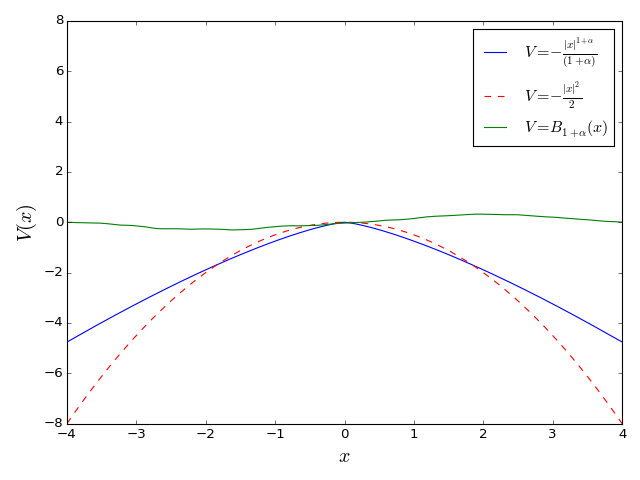

In [4]:
################################################################################
############################### Plots Potentials ###############################
################################################################################

def PlotPotential(Vpara = None,
                  Vcusp = None,
                  Vfbm = None,
                  xmax = 10):
    xfine = np.arange(-xmax, xmax, 2.*xmax/Vfbm.shape[0]).astype(np.float)
    maximum =  max(np.max(abs(Vpara)), np.max(abs(Vcusp)), np.max(abs(Vfbm)))
    ax = plt.figure().add_subplot(111)
    ax.plot(xfine,
            Vcusp,'b-',
            label = '$V =  -\\frac{|x|^{1+ \\alpha}}{(1+\\alpha)}$')
    ax.plot(xfine,
            Vpara,'r--',
            label = '$V = -\\frac{|x|^{2}}{2}$')
    ax.plot(xfine,
            Vfbm,'g',
            label = '$V = B_{1+\\alpha}(x)$')
    ax.legend(loc = "best")
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-maximum, maximum)
    ax.set_xlabel('$x$', fontsize = 18)
    ax.set_ylabel('$V(x)$', fontsize = 18)

ell = 100
n = 1e5
a = 1/3.
xmax = 4

Vfbm =  0.2*SmoothedBrownianPotential(ell, n, 1.3, rseed = 11)
xfine = np.arange(-xmax, xmax, 2.*xmax/Vfbm.shape[0]).astype(np.float)
Vpara =  InvertedOscillatorPotential(xfine)
Vcusp = SmoothConicalPotential(ell, xfine, a)
PlotPotential(Vpara = Vpara,
              Vcusp = Vcusp,
              Vfbm = Vfbm,
              xmax = xmax)

Solving Schroedinger
-----

We supply the Schoedinger equation with initial data in the form of a minimal uncertainty wavepacket
$$\psi_0(x;x_0) = \frac{1}{(2\pi)^{1/4}\sigma^{1/2}}\exp\left(-\frac{|x-x_0|^2}{4\sigma^2}\right)e^{i p_0x/\hbar}$$
Note that since $\hat{p}= \hbar/i \partial_x$, we have that $\hat{p}\psi_0(x) = (p_0+ i\hbar x/\sigma^2 )\psi_0(x)$. As "$\hbar\to0$" this corresponds to fixing an initial moment for the "classical particle".


Roughly speaking, this solver uses a split physical-fourier space method.  That is first it solves 
$
i \hbar \partial_t \psi = V\psi 
$
yielding 
$
\psi(x, t+\Delta t) = \psi(x,t)e^{-iV(x) \Delta t/\hbar}.
$

Then, on the fourier side it solve 
$
i \hbar \partial_t \hat{\psi} = \frac{\hbar^2k^2}{2m}\hat{\psi} 
$
yeilding 
$
\hat{\psi}(k, t+\Delta t) = \hat{\psi}(k,t)e^{-i\hbar^2k^2 \Delta t/2m}.
$

Here are more details on algorithm that it uses

1) Discretize wavefunction to a grid $\psi_n(t)= \psi(x_n,t)$, $V_n= V(x_n)$ and $\hat{\psi}_m= \hat{\psi}(k_n,t)$.

2)  Progress the system by step $\Delta t$.  This involves first computing a "half step" in $x$:
$
x: \psi_n \leftarrow \psi_ne^{-iV(x) (\Delta t/2)/\hbar}
$

3) The calculate $\hat{\psi}_m$ from $\psi_n$ via FFT

4)  Computing a "full step" in $k$:
$
k: \hat{\psi}_m \leftarrow \hat{\psi}_m e^{-i\hbar^2k^2 \Delta t/2m}
$

5) Calculate $\psi_n$ from $\hat{\psi}_m$ via inverse FFT

6) Compute second "half-step" in $x$
$
\psi_n \leftarrow \psi_ne^{-iV(x) (\Delta t/2)/\hbar}
$

7) Repeat

See https://jakevdp.github.io/blog/2012/09/05/quantum-python/ for more information.



In [5]:
################################################################################
############################## Solve Schroedinger ##############################
################################################################################

# Solves the Schroedinger Equation for multiple hbar/m and saves time histories for each in storedData
# If the data already exists, this routine will load it rather recompute.  Additionally it gives 
# Various statistics on runtime for composit routines.

storedData = []
#hbarUsed = 2.**(-np.arange(-7, 11, 1))
hbarUsed = 2.**(-np.arange(-7, 11, 1))
def main():
    computator = [GetData(
                      nsteps = 10,
                      resolution = 2**7,
                      hbar = h,
                      timestep = 1.0)
                  for h in hbarUsed]
    for c in computator:
        print('computing for h = {0}'.format(c.hbar))
        suffix = '_{0}_res_{1}'.format(c.hbar, c.resolution)
        storedData.append(
            (c.compute(base_name = 'data/Scone' + suffix,
                       V = SmoothConicalPotential(
                               c.ell, c.x, 1/3.),
                       base_info = {'roughness' : 1/3,
                                    'ell' : c.ell})))

cProfile.run('main()', 'profile')
p = pstats.Stats('profile')
p.sort_stats('cumulative').print_stats(10)
p.sort_stats('time').print_stats(10)

computing for h = 128.0
inside evolve
(10, 2, 0.5)
computing for h = 64.0
inside evolve
(10, 4, 0.25)
computing for h = 32.0
inside evolve
(10, 8, 0.125)
computing for h = 16.0
inside evolve
(10, 16, 0.0625)
computing for h = 8.0
inside evolve
(10, 32, 0.03125)
computing for h = 4.0
inside evolve
(10, 64, 0.015625)
computing for h = 2.0
inside evolve
(10, 128, 0.0078125)
computing for h = 1.0
inside evolve
(10, 256, 0.00390625)
computing for h = 0.5
inside evolve
(10, 512, 0.001953125)
computing for h = 0.25
inside evolve
(10, 1024, 0.0009765625)
computing for h = 0.125
inside evolve
(10, 2048, 0.00048828125)
computing for h = 0.0625
inside evolve
(10, 4096, 0.000244140625)
computing for h = 0.03125
inside evolve
(10, 8192, 0.0001220703125)
computing for h = 0.015625
inside evolve
(10, 16384, 6.103515625e-05)
computing for h = 0.0078125
inside evolve
(10, 32768, 3.0517578125e-05)
computing for h = 0.00390625
inside evolve
(10, 65536, 1.52587890625e-05)
computing for h = 0.001953125
ins

<pstats.Stats instance at 0x1057bfdd0>

Wavefunction Measurement and Dispersion
---

In the case of a free Gaussian wavepacket, we can solve Schroedinger's equation analytically.  The result is the following
\begin{equation}
\psi(x,t) = \frac{1}{\pi^{1/4}\sqrt{\sigma\beta(t)}} e^{i(p_0x-E(p_0)t)/\hbar} e^{-[x-x_0-(p_0/m)t]^2/(2\sigma^2\beta(t))}
\end{equation}
where $\beta(t)= 1 + i\frac{\hbar t}{m \sigma^2}$ and $E(p_0)= p_0^2/2m$. Showing our evolution of a free wavepacket agrees with the analytic form will be a check on our code.  The analytic form for the dispersion for this free wave packet is
\begin{equation}
\Delta x(t) = \frac{\sigma}{\sqrt{2}} \sqrt{1 + \left(\frac{\hbar t}{m \sigma^2}\right)^2}
\end{equation}
#### We calculate the dispersion of the wavefuntion $\psi(t)$ in the following way:

\begin{equation} 
\Delta x(t) = \left(\int_{\mathbb{R}} x^2|\psi(t)|^2 {\rm d} x - \left|\int_{\mathbb{R}} x |\psi(t)|^2 {\rm d} x \right|^2 \right)^{1/2}, \ \ \ \ \ \ \Delta k(t) = \left(\int_{\mathbb{R}}  k^2 |\hat{\psi}_k(t)|^2 {\rm d} k - \left|\int_{\mathbb{R}}  k |\hat{\psi}_k(t)|^2 {\rm d} k \right|^2 \right)^{1/2},  \ \ \ \ \ \ \Delta p(t) =  \hbar*\Delta k(t).
\end{equation}


In [58]:
################################################################################
###################### Checks Conservation Probability #########################
################################################################################

def CheckProbabilityConservation(t = 2):
    ProbX = [0 for i in range(len(storedData))]
    ProbK = [0 for i in range(len(storedData))]
    for i in range(len(storedData)):
        ProbX[i] = np.sum((np.abs(storedData[i].psi_x_full[t])**2)*storedData[i].dx)
        ProbK[i] = np.sum((np.abs(storedData[i].psi_k_full[t])**2)*storedData[i].dk)
    return ProbX, ProbK


################################################################################
##################### Visualizations and Data Anaylsis #########################
################################################################################
################## Calculate Probability Time Evolution ########################
################################################################################

def getMaxima(t = 2):
    max_psi_x = []
    max_psi_k = []
    for i in range(len(storedData)):
        max_psi_x.append(np.max(np.abs(storedData[i].psi_x_full[t])**2))
        max_psi_k.append(np.max(np.abs(storedData[i].psi_k_full[t])**2))
    return max_psi_x, max_psi_k

def snapshop_position_wavefunction(
        tf = 20,
        data = storedData[0],
        minx = -20,
        maxx = 20,
        yheight = 20,
        prefix = 'bla'):    
    h = data.hbar
    a =  h**(0.5)   
    if tf > data.dispersion_vs_t.shape[0]:
        print 'final time greater than simulation time, setting equal.'
        tf = data.dispersion_vs_t.shape[0]
    time = np.arange(0, tf).astype(np.float)    
    ExtCharX = ExtremalCharacteristics(time, 1/3.)    
    fig = plt.figure(figsize=(8, 4))
    axw = fig.add_subplot(111)
    for observation_time in time:
        axw.cla()
        axw.axvline(- ExtCharX[observation_time], color = 'black', linestyle='dashed', linewidth=0.5)
        axw.axvline(  ExtCharX[observation_time], color = 'black', linestyle='dashed', linewidth=0.5)
        axw.plot(data.x,
                 np.abs(data.psi_x_full[observation_time])**2,'b-',
                 color = 'black', linestyle='solid', linewidth=1.5)
        axw.set_title("$t$ = {0}".format(observation_time))
        axw.legend(loc = "best")
        axw.set_xlim(minx, maxx)
        axw.set_ylim(0, yheight)
        axw.set_xlabel('$x$', fontsize = 18)
        axw.set_ylabel('$|\\psi(x,t)|^2$', fontsize = 18)     
        fig.savefig('figs/' + prefix + '_frame_{0}.png'.format(observation_time),
                    format = 'png')
    subprocess.call(['convert', '-delay', '25', 'figs/' + prefix + '_frame*.png', 'movies/' + prefix + '.gif'])
    
def snapshop_momentum_wavefunction(
        tf = 20,
        data = storedData[0],
        mink = -20,
        maxk = 20,
        yheightK = 20,
        prefix = 'bla'):   
    h = data.hbar
    a =  h**(0.5)  
    if tf > data.dispersion_vs_t.shape[0]:
        print 'final time greater than simulation time, setting equal.'
        tf = data.dispersion_vs_t.shape[0]
    time = np.arange(0, tf).astype(np.float)
    ExtCharP = ExtremalCharacteristicsK(time, 1/3.)
    fig = plt.figure(figsize=(8, 4))
    axd = fig.add_subplot(111)
    for observation_time in time:
        axd.cla()
        axd.axvline(- ExtCharP[observation_time], color = 'black', linestyle='dashed', linewidth=0.5)
        axd.axvline(  ExtCharP[observation_time], color = 'black', linestyle='dashed', linewidth=0.5)
        axd.plot(h*data.k,
                 np.abs(data.psi_k_full[observation_time])**2/h,'b-',
                 color = 'black', linestyle='solid', linewidth=1.5)
        axd.set_title("$t$ = {0}".format(observation_time))
        axd.set_xlim(mink, maxk)
        axd.set_ylim(0, yheightK)
        axd.legend(loc = "best")
        axd.set_xlabel('$p$', fontsize = 18)
        axd.set_ylabel('$|\\hat{\\psi}(p,t)|^2$', fontsize = 18)
        fig.savefig('figs/' + prefix + '_frame_{0}.png'.format(observation_time),
                    format = 'png')
    subprocess.call(['convert', '-delay', '25', 'figs/' + prefix + '_frame*.png', 'movies/' + prefix + '.gif'])
    

def make_timeEvolution_movies(T = 10, domainsize = 100, kdomainsize = 100):
    ExtCharX = ExtremalCharacteristics(T, 1/3.)
    ExtCharP = ExtremalCharacteristicsK(T, 1/3.)
    Max_psi_x, Max_psi_k = getMaxima(T)
    for i in range(len(storedData)):
        snapshop_position_wavefunction(prefix = 'Pos_Evolution_for_hbar_{0}'.format(hbarUsed[i]),
                              tf = T + 1,
                              data = storedData[i],
                              minx = - domainsize,
                              maxx =   domainsize,
                              yheight = 1.5*Max_psi_x[i])
        snapshop_momentum_wavefunction(prefix = 'Mom_Evolution_for_hbar_{0}'.format(hbarUsed[i]),
                              tf = T + 1,
                              data = storedData[i],
                              mink = - ExtCharP - 10,
                              maxk =   ExtCharP + 10,
                              yheightK = 1.5*Max_psi_k[i]/storedData[i].hbar)
    return None


################################################################################
######################### Dispersion Plots/Change h ############################
################################################################################

def get_dispersion_vs_h(tf,
        hlist = [],
        prefix = 'Scone'):
    dispx = []
    dispk = []
    for h in hlist:
        suffix = '_{0}_res_{1}'.format(h, 2**7)
        c = read_solution(base_name = 'data/' + prefix + suffix)
        dispx.append(c.dispersion_vs_t[tf])
        dispk.append(c.kdispersion_vs_t[tf])
    return np.array(dispx), np.array(dispk)

def plot_dispersion_vs_hbar(tf = 1,
                            alpha = 1/3.): 
    asymptdisp =  [pure_cusp_dispersion(tf, alpha) for i in range(len(hbarUsed))]
    asymptdispk = [pure_cusp_k_dispersion(tf, alpha) for i in range(len(hbarUsed))]
    CuspDisp = get_dispersion_vs_h(tf = tf,
                                hlist = hbarUsed,
                                prefix = 'Scone')
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    #ax = plt.figure().add_subplot(111)
    ax.plot(hbarUsed, CuspDisp[0]**2, color = 'black', linestyle='solid', linewidth=1.5)
    ax.plot(hbarUsed, CuspDisp[1]**2*hbarUsed**2, color = 'black', linestyle='dashed', linewidth=1.5)
    ax.plot(hbarUsed,
            asymptdisp, color = 'black', linestyle='solid', linewidth=0.5)
    ax.plot(hbarUsed,
            asymptdispk, color = 'black', linestyle='dashed', linewidth=0.5)
    ax.set_xlim(hbarUsed[-1], hbarUsed[0])
    ax.legend(loc = "best")
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xscale('log')
    ax.set_xlabel('$\\hbar/m$', fontsize = 18)
    ax.set_ylabel('$(\\Delta x(t))^2{\\rm \ and\ } \ \ (\\Delta p(t))^2$', fontsize = 18)
    ax.set_yscale('log')
    #ax.set_title("Semiclassical Limit of Dispersion")
    
def Change_hbar_Movie(T = 5):
    if T > storedData[0].dispersion_vs_t.shape[0]:
        print 'time greater than simulation time, setting equal.'
        T = storedData[0].dispersion_vs_t.shape[0]    
    ExtCharX = ExtremalCharacteristics(T, 1/3.)
    ExtCharP = ExtremalCharacteristicsK(T, 1/3.)
    Max_psi_x, Max_psi_k = getMaxima(T)   
    
    fig1 = plt.figure(figsize=(8, 4))
    axw = fig1.add_subplot(111)
    for i in range(1,len(storedData)):
        h = storedData[i].hbar
        a =  h**(0.5)
        axw.cla()
        axw.axvline(- ExtCharX, color = 'black', linestyle='dashed', linewidth=0.5)
        axw.axvline(  ExtCharX, color = 'black', linestyle='dashed', linewidth=0.5)
        axw.plot(storedData[i].x,
                 np.abs(storedData[i].psi_x_full[T])**2,'b-',
                 color = 'black', linestyle='solid', linewidth=1.5)
        axw.legend(loc = "best")
        axw.set_title("$\\hbar/m$ = {0}".format(h))
        axw.set_xlim(-200, 200)
        axw.set_ylim(0, 1.05*Max_psi_x[i])
        axw.set_xlabel('$x$', fontsize = 18)
        axw.set_ylabel('$|\\psi(x,t)|^2$', fontsize = 18)
        fig1.savefig('figs/' + 'pos_fixed_t_change_h' + '_frame_{0:0>2}.png'.format(i),
                    format = 'png')
    subprocess.call(['convert', '-delay', '25', 'figs/' + 'pos_fixed_t_change_h'
                     + '_frame*.png', 'movies/' + 'pos_fixed_t_change_h' + '.gif']) 
    
    fig2 = plt.figure(figsize=(8, 4))
    axd = fig2.add_subplot(111)
    for i in range(1,len(storedData)):
        h = storedData[i].hbar
        a =  h**(0.5)
        axd.cla()      
        axd.axvline(- ExtCharP, color = 'black', linestyle='dashed', linewidth=0.5)
        axd.axvline(  ExtCharP, color = 'black', linestyle='dashed', linewidth=0.5)
        axd.plot(h*storedData[i].k,
                 np.abs(storedData[i].psi_k_full[T])**2/h,'b-',
                 color = 'black', linestyle='solid', linewidth=1.5)
        axd.set_xlim(- ExtCharP - 50, ExtCharP + 50)
        axd.set_ylim(0, 1.05*Max_psi_k[i]/storedData[i].hbar)
        axd.legend(loc = "best")
        axd.set_title("$\\hbar/m$ = {0}".format(h))
        axd.set_xlabel('$p$', fontsize = 18)
        axd.set_ylabel('$|\hat{\\psi}(p,t)|^2$', fontsize = 18)
        fig2.savefig('figs/' + 'mom_fixed_t_change_h' + '_frame_{0:0>2}.png'.format(i),
                    format = 'png')
    subprocess.call(['convert', '-delay', '25', 'figs/' + 'mom_fixed_t_change_h' 
                     + '_frame*.png', 'movies/' + 'mom_fixed_t_change_h' + '.gif'])
    
################################################################################
############################## Calculate Phase #################################
################################################################################

def CalculatePhase(t = 2):
    wavefunctionPhase = []
    wavefunctionEnvelope= []
    for i in range(len(storedData)):
        wavefunctionPhase.append(np.real(storedData[i].psi_x_full[t])**2)
        wavefunctionEnvelope.append(np.abs(storedData[i].psi_x_full[t])**2)
    return wavefunctionPhase, wavefunctionEnvelope
        
def PhaseEvolutionFuncHbar(tf = 6):
    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    observation_time = tf
    for i in range(6,len(storedData)):     # entry 7 is hbar of 1
        h = storedData[i].hbar
        Phase, Envelope = CalculatePhase(observation_time)
        E = Envelope[i]
        E1 = E[int(len(E)/2):len(E)]
        ind_max =  np.argmax(E1) + int(len(E)/2)
        E2 = E[ind_max:len(E)]
        ind_half_max = np.argmin(np.abs(E[ind_max]/2 - E2)) + ind_max
        max_location = storedData[i].x[ind_max]
        half_max_location = storedData[i].x[ind_half_max]
        half_width = np.abs(max_location - half_max_location)
        ax.cla()
        ax.plot(storedData[i].x, Phase[i], color = 'black', linestyle='solid', linewidth=0.5)
        ax.plot(storedData[i].x, Envelope[i], color = 'black', linestyle='solid', linewidth=2)
        ax.set_xlim(max_location - 2*half_width, max_location + 2*half_width)
        ax.set_ylim(0, 1.05*E[ind_max])
        ax.set_xlabel('$x$', fontsize = 18)
        ax.set_ylabel('$|{\\rm Re}(\\psi)|^2$', fontsize = 18)
        ax.set_title("$\\hbar/m$ = {0}".format(h))
        ax.legend(loc = "best")
        fig.savefig('figs/' + 'phase_evolution' + '_frame_{0}.png'.format(100 + i),
                     format = 'png')
    subprocess.call(['convert', '-delay', '25', 'figs/' + 'phase_evolution' +
                     '_frame*.png', 'movies/' + 'phase_evolution' + '.gif'])
    

Data Analysis and Plots
---

In [29]:
CheckProbabilityConservation(t = 6)

([1.0,
  0.99999999999999967,
  1.0,
  1.0000000000000009,
  1.0000000000000013,
  1.0000000000000009,
  0.99999999999999867,
  1.0000000000000013,
  1.0000000000000031,
  1.0000000000000946,
  1.0000000000002514,
  1.0000000000002953,
  1.0000000000003988,
  1.0000000000005695,
  1.0000000000016169,
  1.0000000000013329,
  1.0000000000020308,
  1.0000000000031402],
 [1.0000000000000007,
  0.99999999999999978,
  1.0000000000000004,
  1.0000000000000009,
  1.0000000000000013,
  1.0000000000000009,
  0.999999999999999,
  1.000000000000002,
  1.0000000000000036,
  1.000000000000095,
  1.0000000000002516,
  1.0000000000002955,
  1.0000000000003986,
  1.0000000000005698,
  1.0000000000016176,
  1.0000000000013332,
  1.000000000002031,
  1.0000000000031419])

<IPython.core.display.Javascript object>


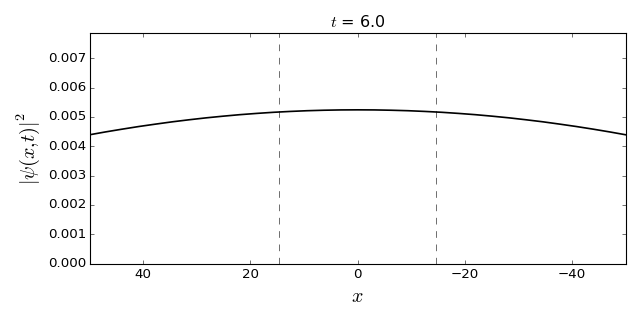

<IPython.core.display.Javascript object>


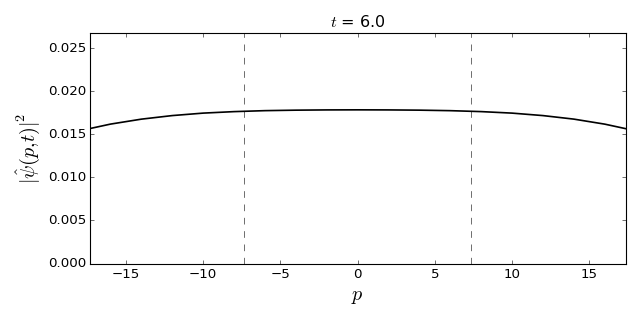

<IPython.core.display.Javascript object>


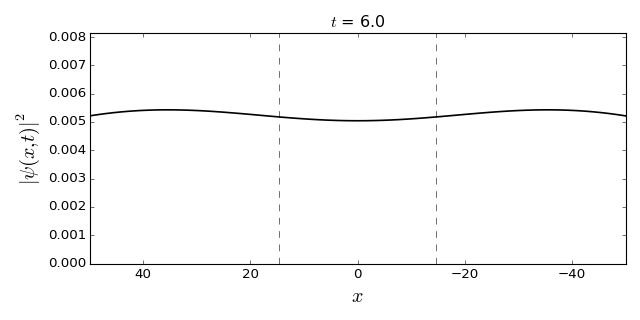

<IPython.core.display.Javascript object>


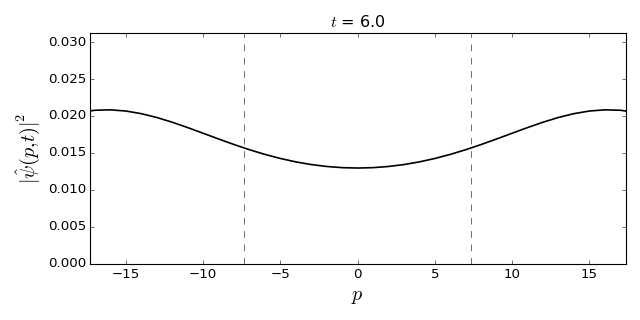

<IPython.core.display.Javascript object>


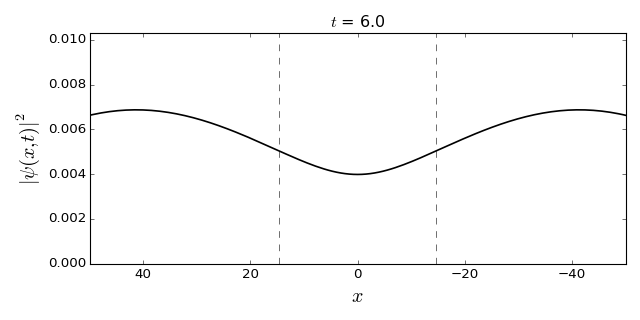

<IPython.core.display.Javascript object>


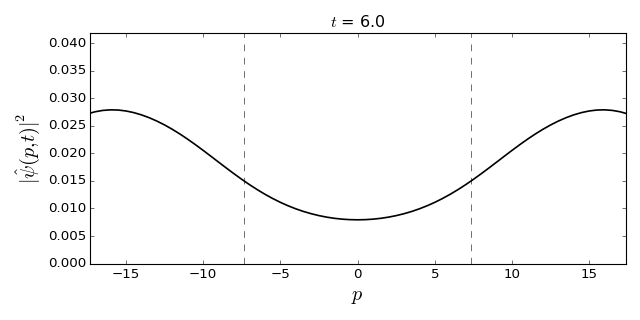

<IPython.core.display.Javascript object>


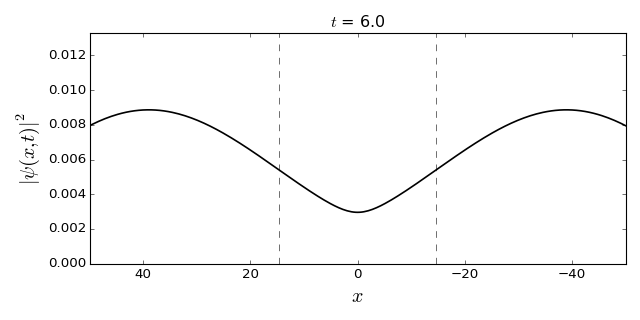

<IPython.core.display.Javascript object>


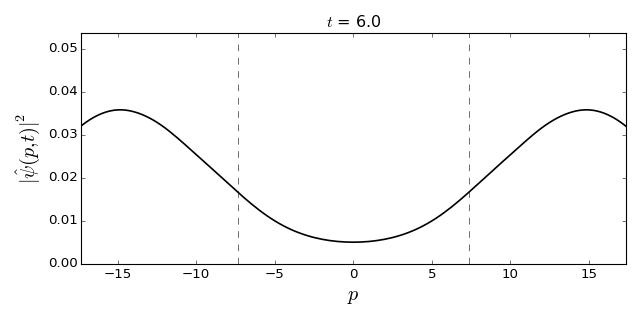

<IPython.core.display.Javascript object>


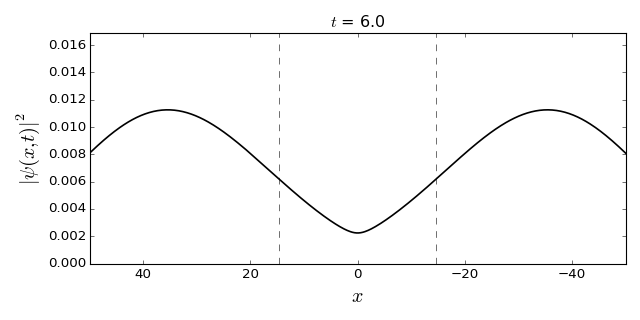

<IPython.core.display.Javascript object>


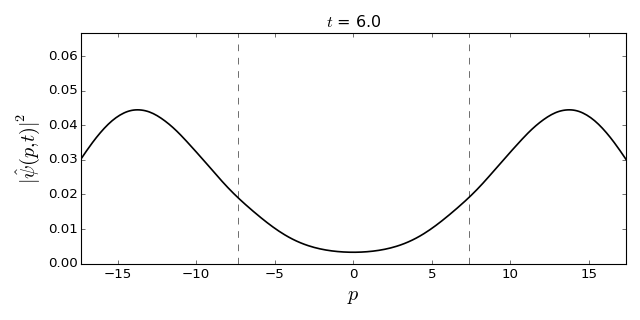

<IPython.core.display.Javascript object>


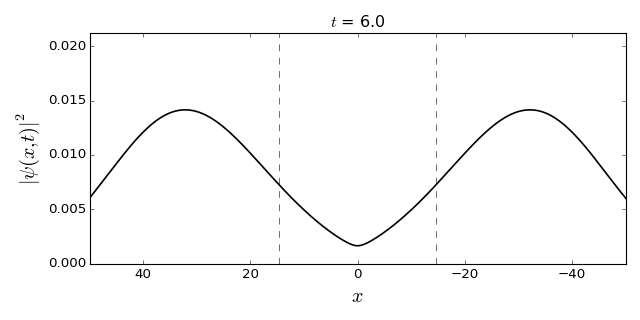

<IPython.core.display.Javascript object>


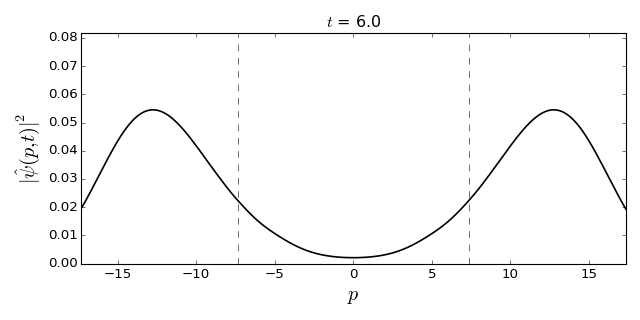

<IPython.core.display.Javascript object>


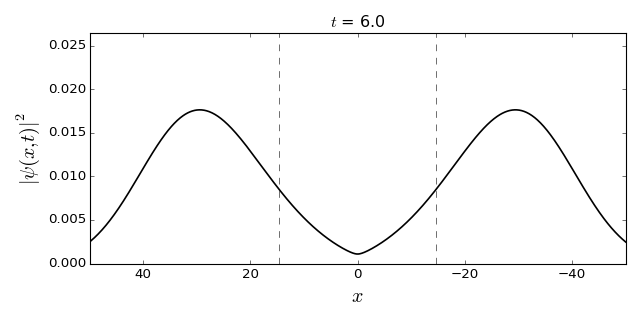

<IPython.core.display.Javascript object>


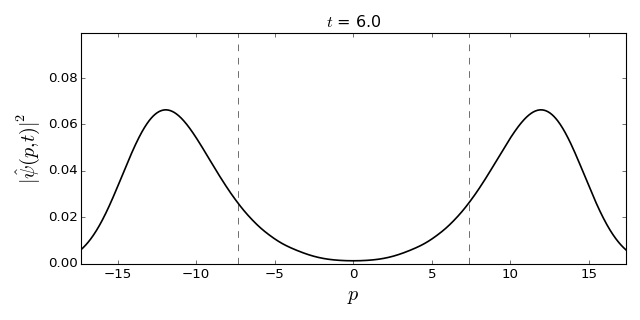

<IPython.core.display.Javascript object>


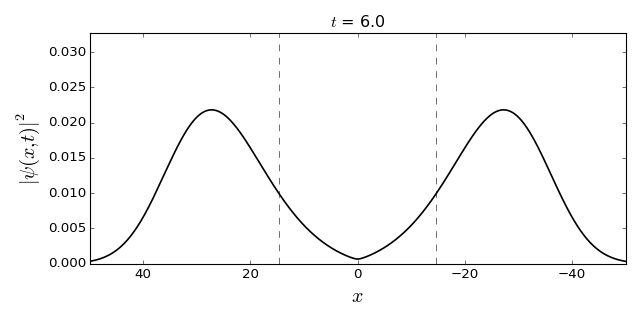

<IPython.core.display.Javascript object>


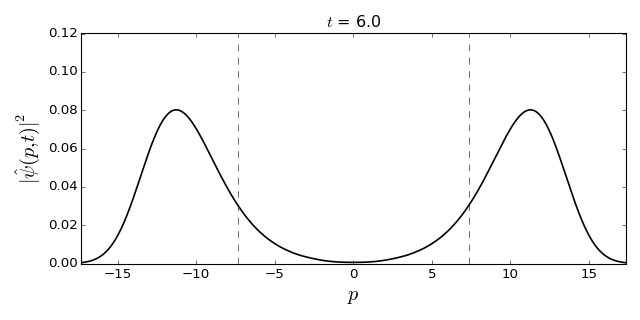

<IPython.core.display.Javascript object>


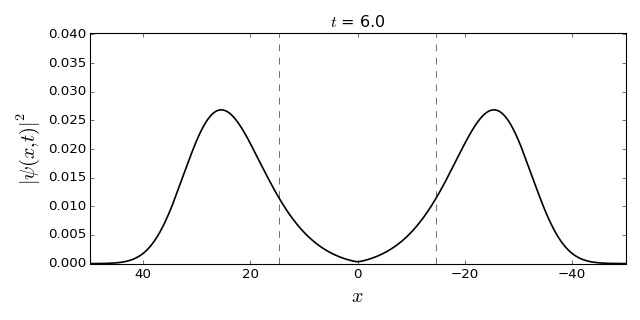

<IPython.core.display.Javascript object>


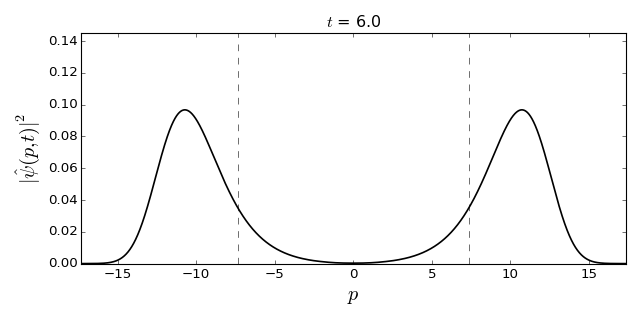

<IPython.core.display.Javascript object>


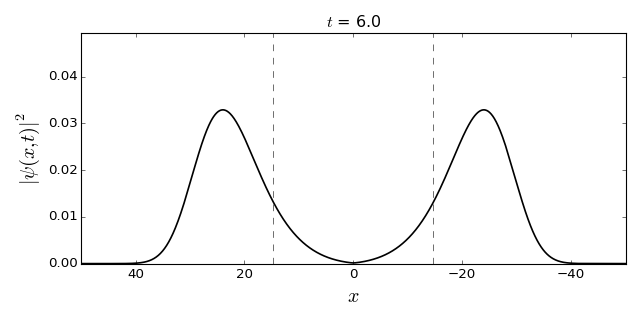

<IPython.core.display.Javascript object>


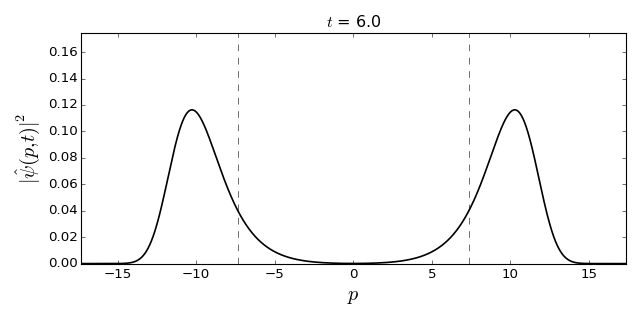

<IPython.core.display.Javascript object>


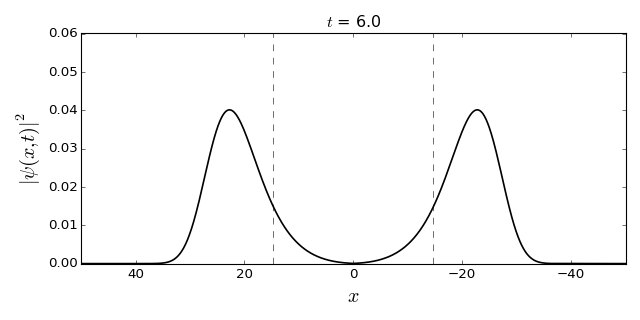

<IPython.core.display.Javascript object>


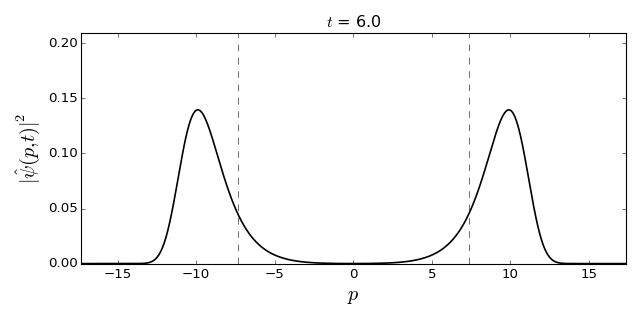

<IPython.core.display.Javascript object>


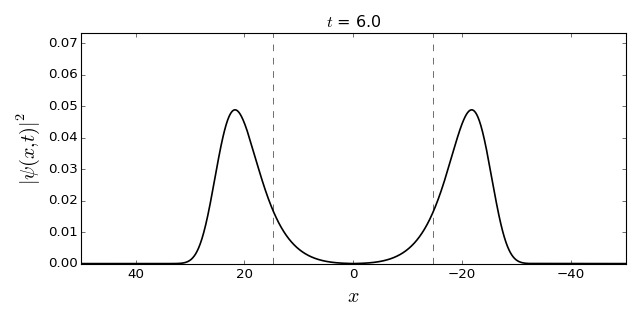

<IPython.core.display.Javascript object>


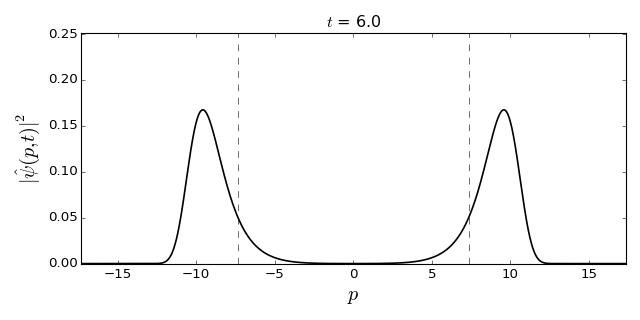

<IPython.core.display.Javascript object>


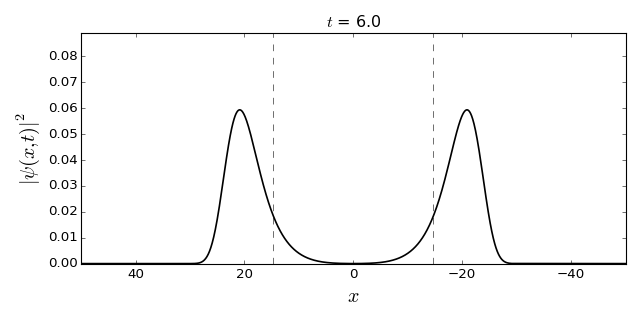

<IPython.core.display.Javascript object>


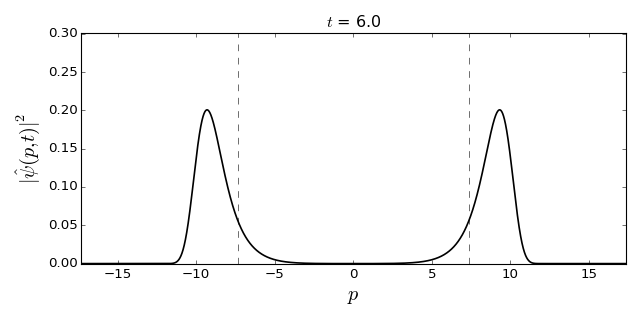

<IPython.core.display.Javascript object>


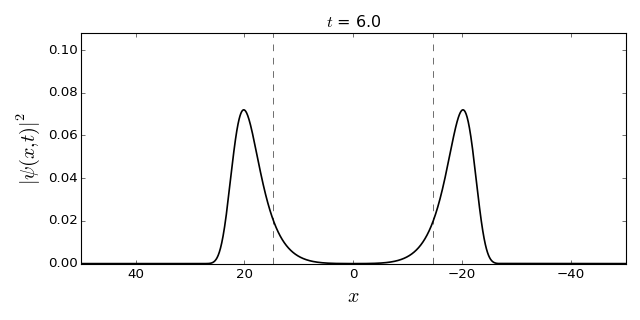

<IPython.core.display.Javascript object>


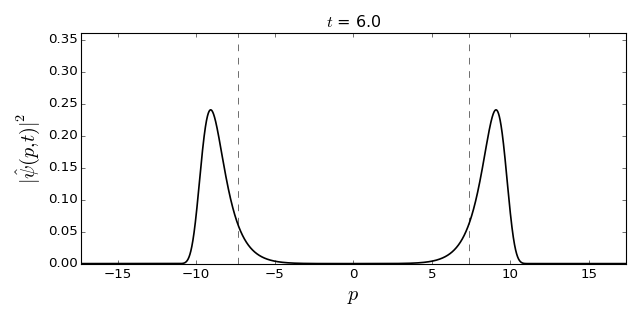

<IPython.core.display.Javascript object>


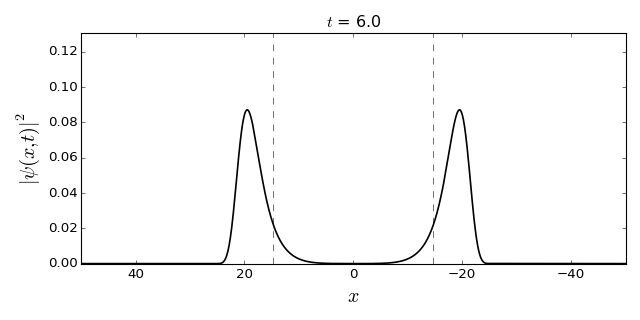

<IPython.core.display.Javascript object>


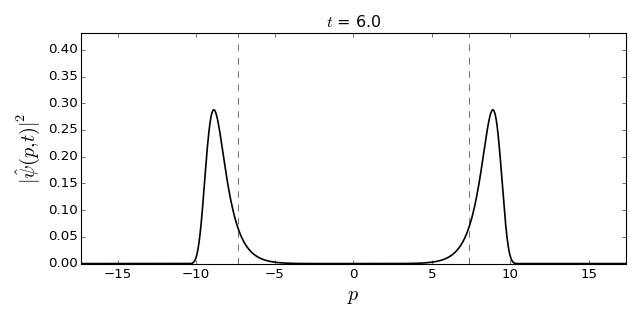

<IPython.core.display.Javascript object>


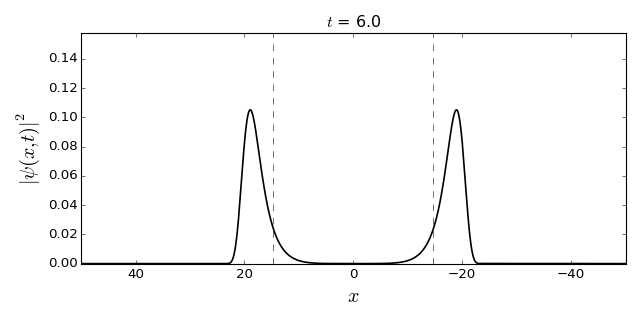

<IPython.core.display.Javascript object>


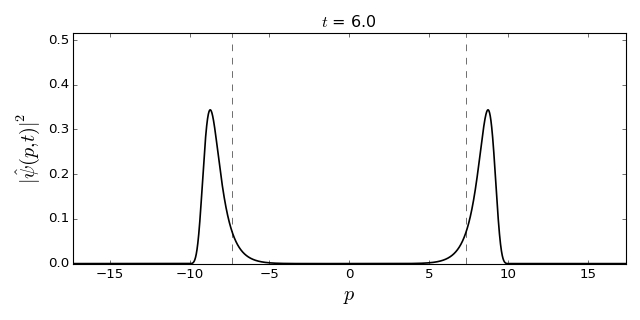

<IPython.core.display.Javascript object>


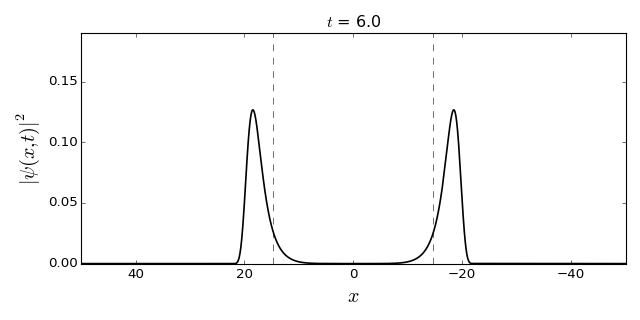

<IPython.core.display.Javascript object>


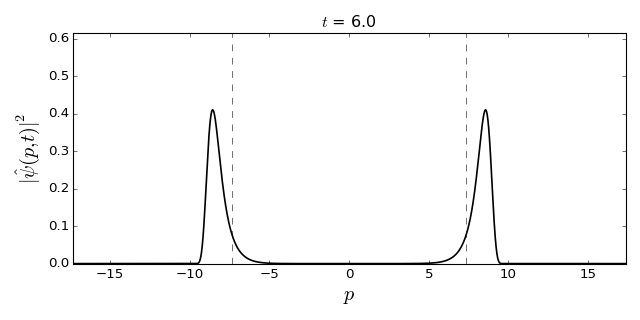

<IPython.core.display.Javascript object>


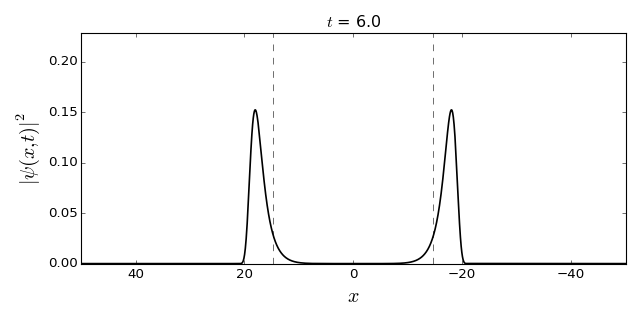

<IPython.core.display.Javascript object>


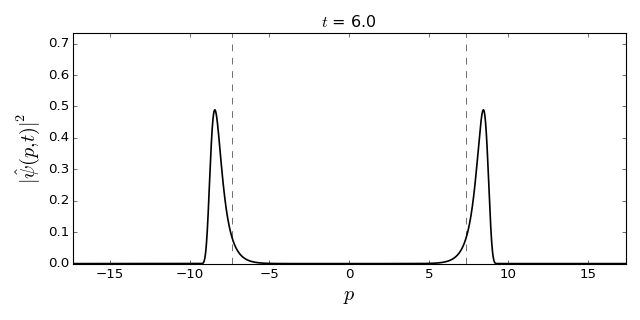

In [55]:
make_timeEvolution_movies(T = 6, domainsize = -50)

<IPython.core.display.Javascript object>


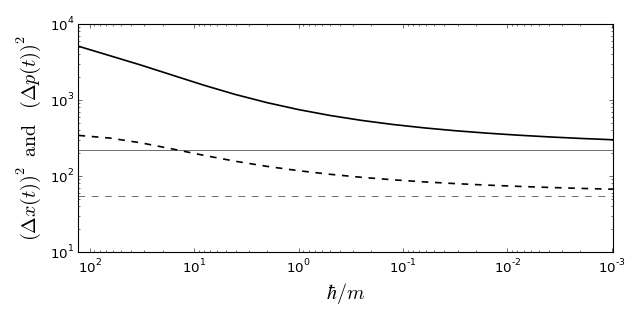

In [50]:
plot_dispersion_vs_hbar(tf = 6, alpha = 1/3.)

<IPython.core.display.Javascript object>


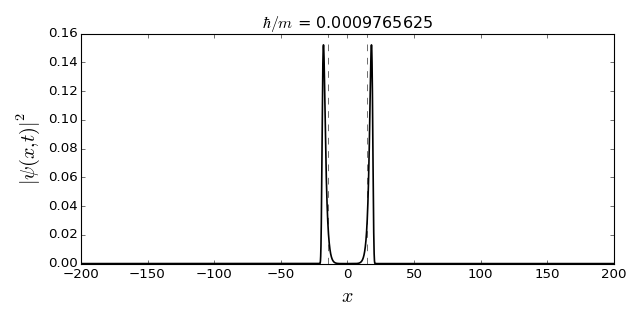

<IPython.core.display.Javascript object>


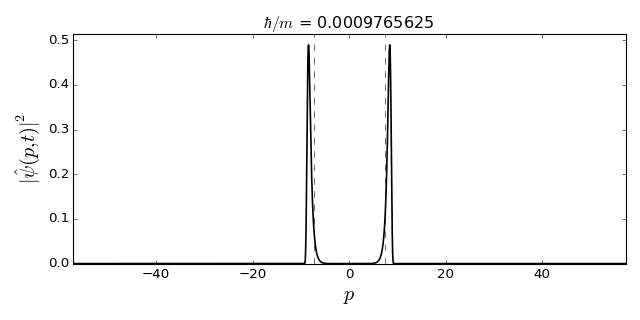

In [59]:
Change_hbar_Movie(T = 6)

<IPython.core.display.Javascript object>


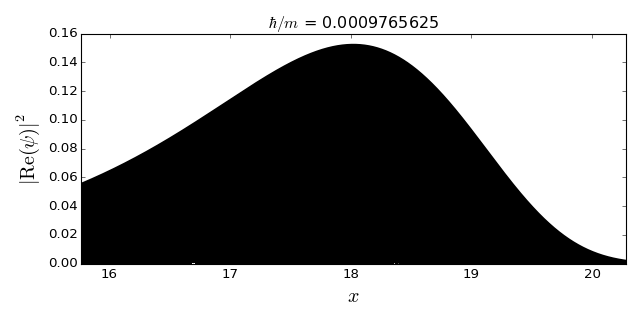

In [57]:
PhaseEvolutionFuncHbar(tf = 6)